Resolved paths:
  train.csv: /kaggle/working/walmart_unzipped/train.csv
  features.csv: /kaggle/working/walmart_unzipped/features.csv
  stores.csv: /kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
  test.csv: /kaggle/working/walmart_unzipped/test.csv
  sampleSubmission.csv: /kaggle/working/walmart_unzipped/sampleSubmission.csv
Rows: 421570 | Unique stores: 45 | Unique depts: 81
   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   

   MarkDown1  MarkDown2  MarkDown3  ...  MarkDown3_missing  MarkDown4_missing  \
0        0.0        0.0        0.0  ...                  1                  1   
1        0.0        0.0        0.0  ...                  1                  1   
2        0.0        0.0        0.0  ... 

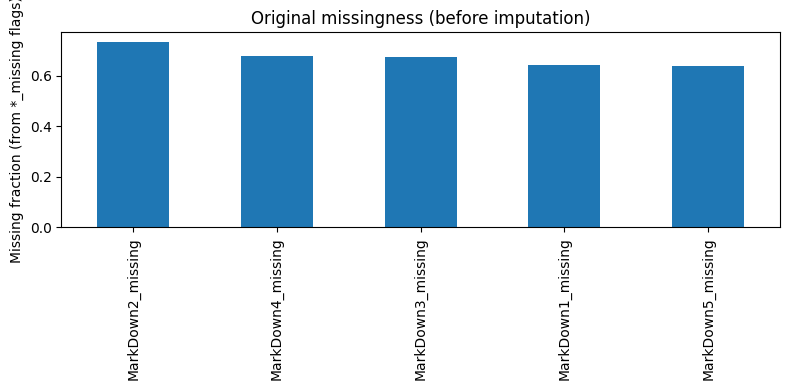

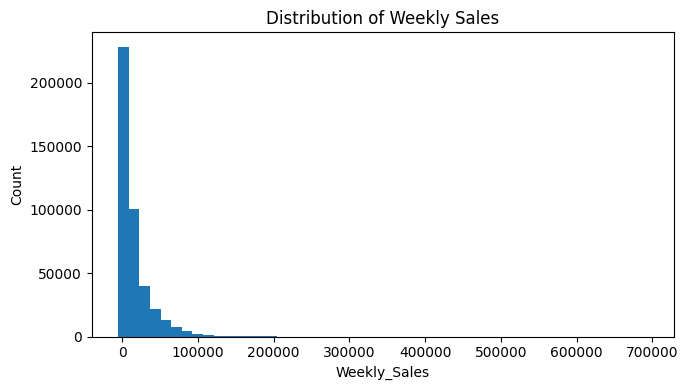

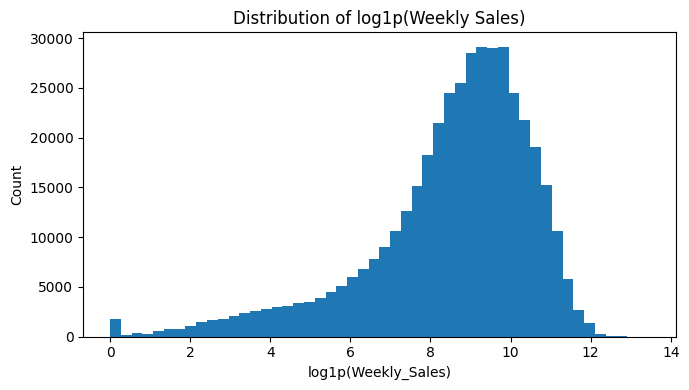

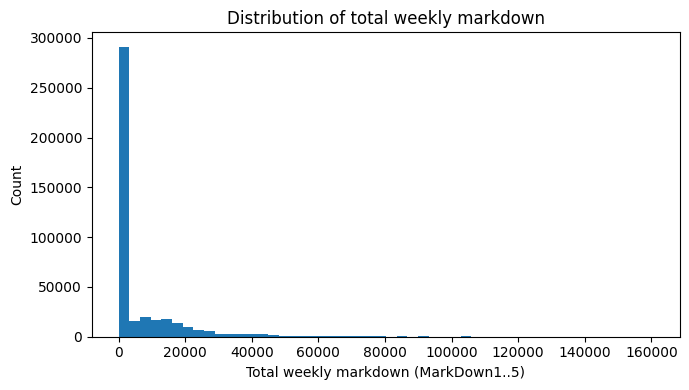

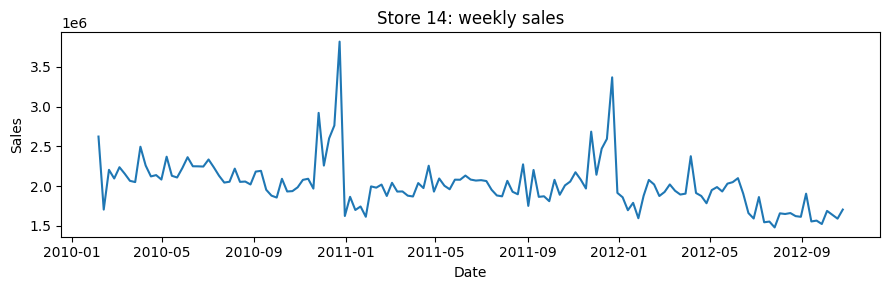

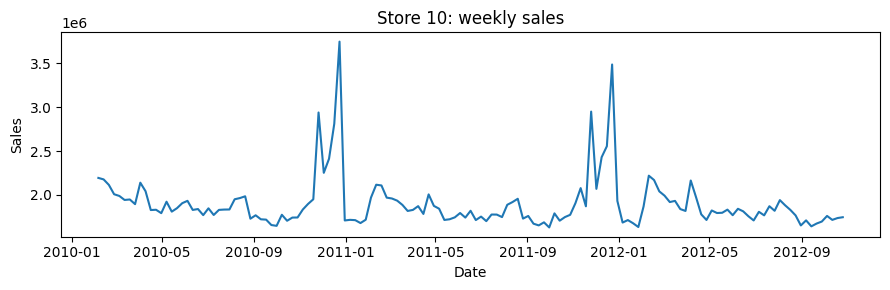

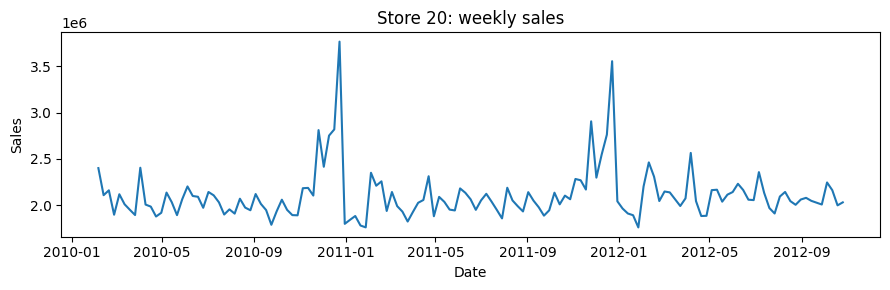

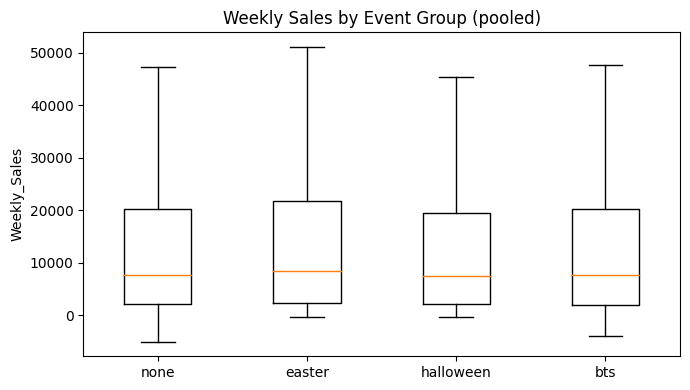

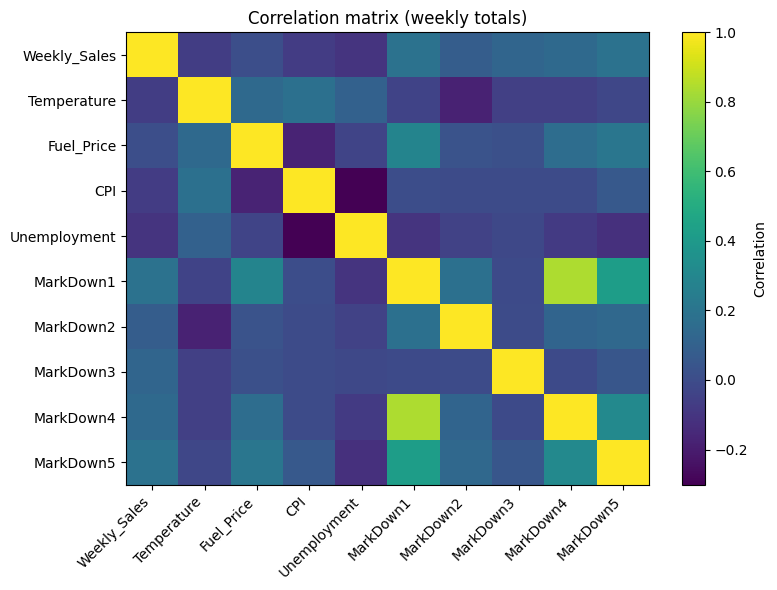


=== One-way ANOVA across event groups (pooled) ===
[ANOVA] Weekly_Sales across (none,easter,halloween,bts): F=10.711, p=4.91e-07

[Tukey HSD] Pairwise differences between event groups:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1    group2   meandiff  p-adj    lower      upper    reject
------------------------------------------------------------------
      bts    easter  1231.1975    0.0   564.8978  1897.4972   True
      bts halloween  -767.5008  0.065 -1566.4151    31.4134  False
      bts      none    30.9549 0.9907   -234.799   296.7088  False
   easter halloween -1998.6983    0.0 -2978.6828 -1018.7139   True
   easter      none -1200.2426    0.0  -1826.925  -573.5602   True
halloween      none   798.4557 0.0373    32.2707  1564.6407   True
------------------------------------------------------------------

Building store-level features…


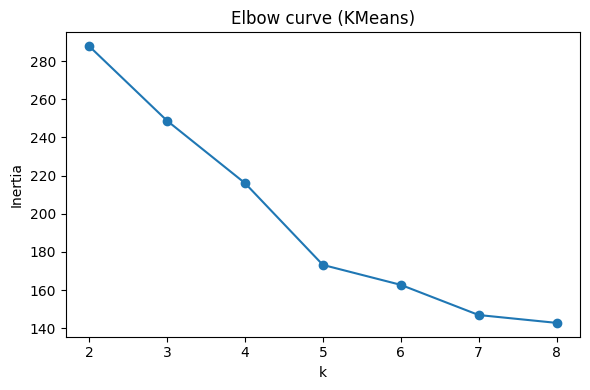

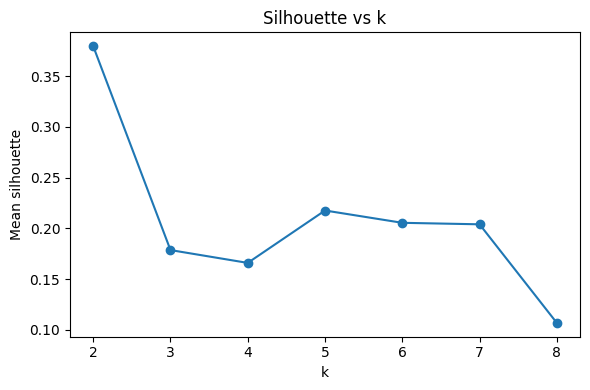

Chosen k via max silhouette: k=2


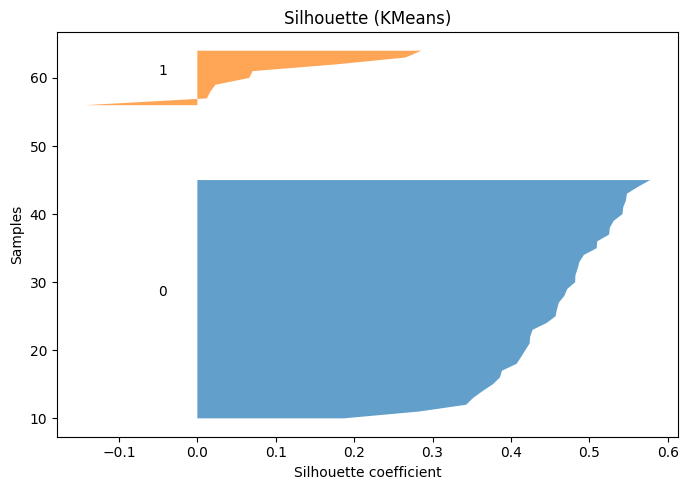

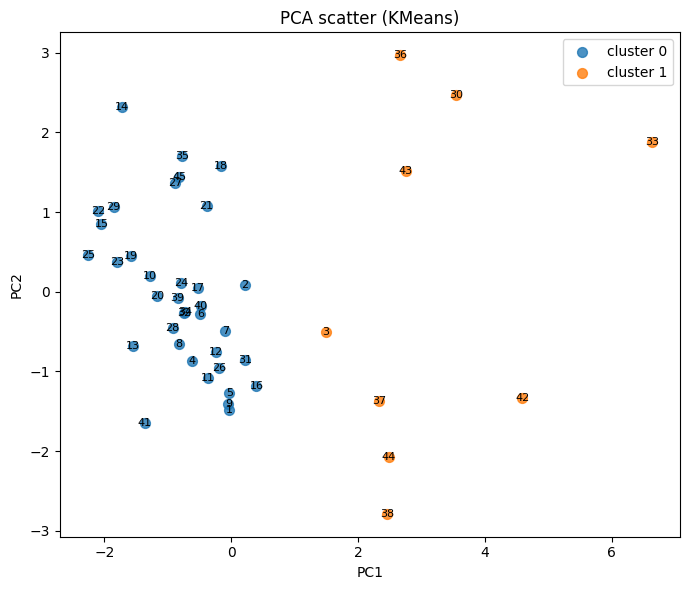

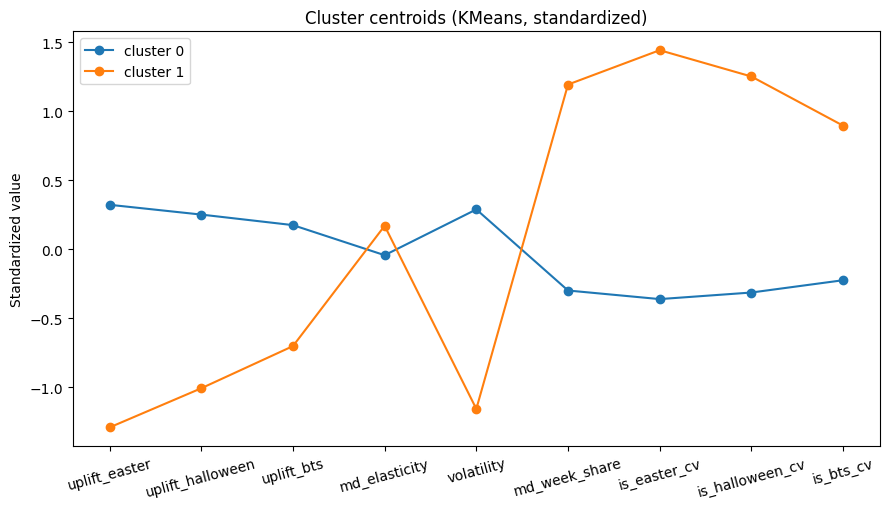

[KMeans] metrics: {'silhouette': 0.3796610902928385, 'calinski_harabasz': 17.496802506671283, 'davies_bouldin': 1.3673805362236326, 'n_clusters': 2}


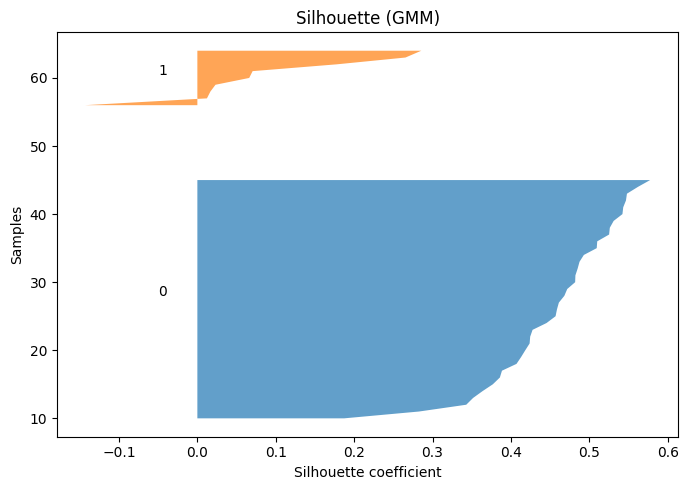

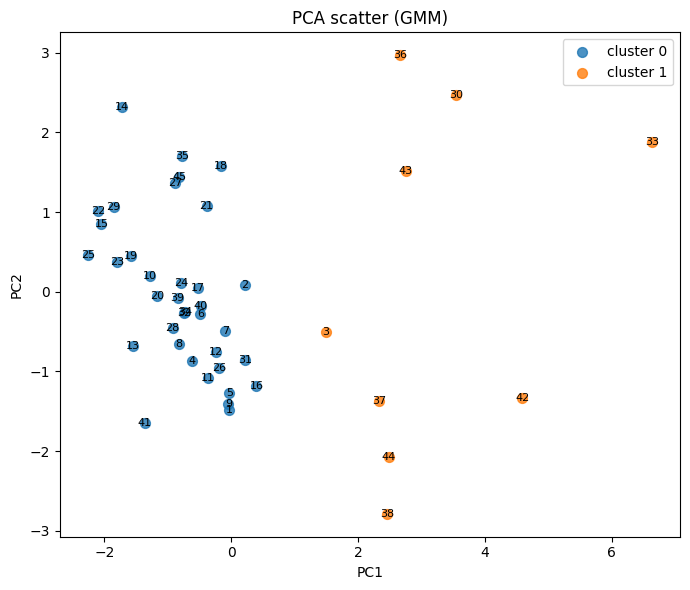

[GMM] metrics: {'silhouette': 0.3796610902928385, 'calinski_harabasz': 17.496802506671283, 'davies_bouldin': 1.3673805362236326, 'n_clusters': 2}


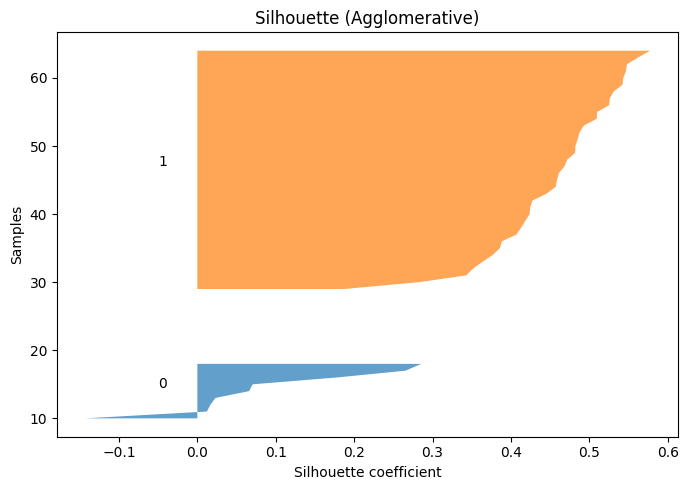

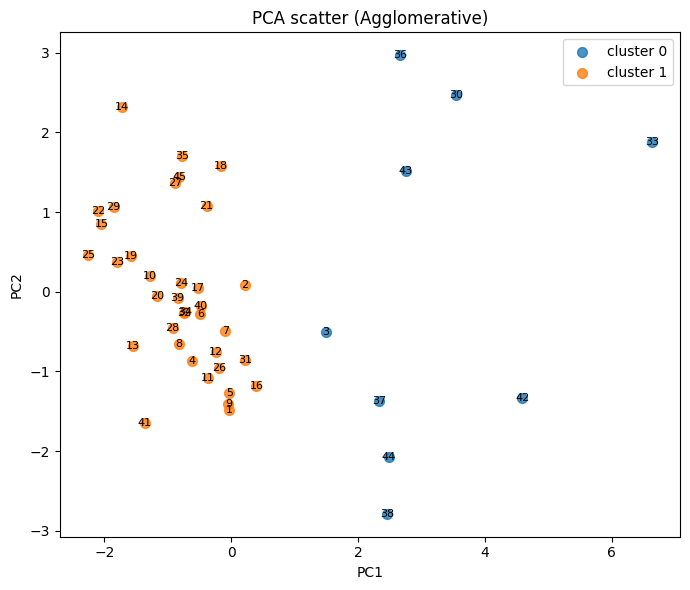

[Agglomerative] metrics: {'silhouette': 0.3796610902928385, 'calinski_harabasz': 17.496802506671283, 'davies_bouldin': 1.3673805362236326, 'n_clusters': 2}


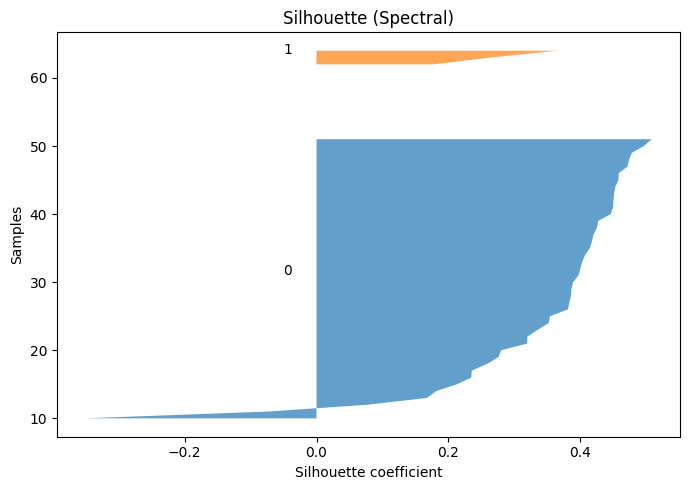

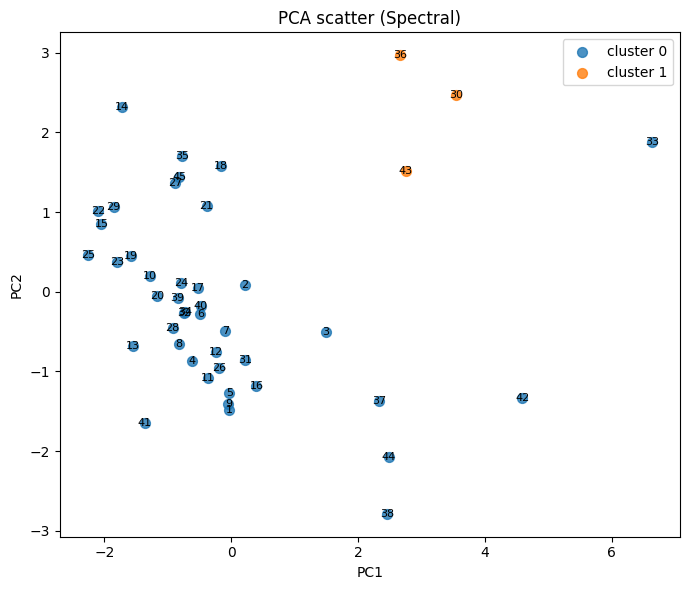

[Spectral] metrics: {'silhouette': 0.3384619711697083, 'calinski_harabasz': 6.199097875896608, 'davies_bouldin': 1.1641387579011242, 'n_clusters': 2}


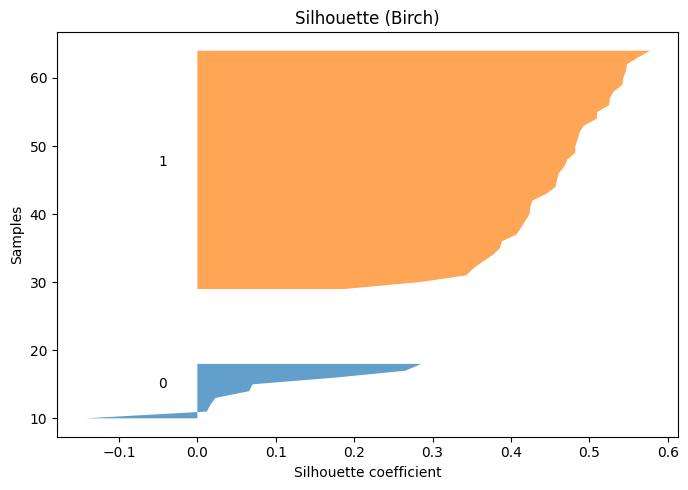

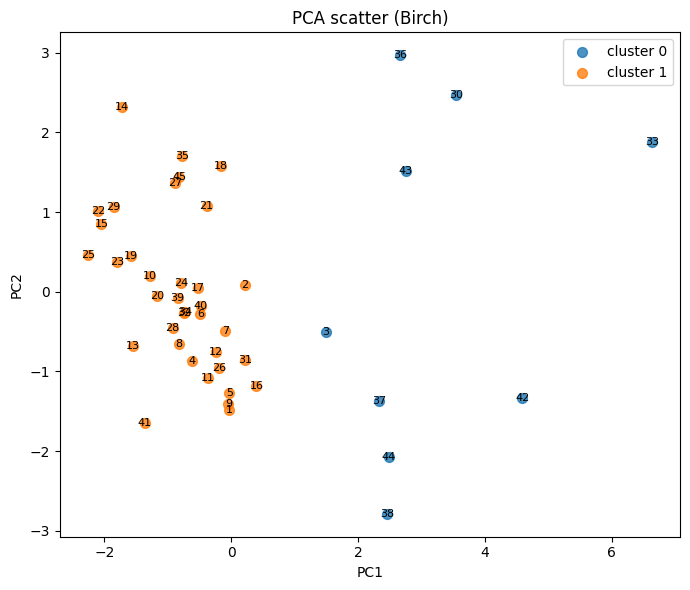

[Birch] metrics: {'silhouette': 0.3796610902928385, 'calinski_harabasz': 17.496802506671283, 'davies_bouldin': 1.3673805362236326, 'n_clusters': 2}
KMedoids skipped (install scikit-learn-extra to enable).
Silhouette (DBSCAN): skipped (need >=2 non-noise clusters).


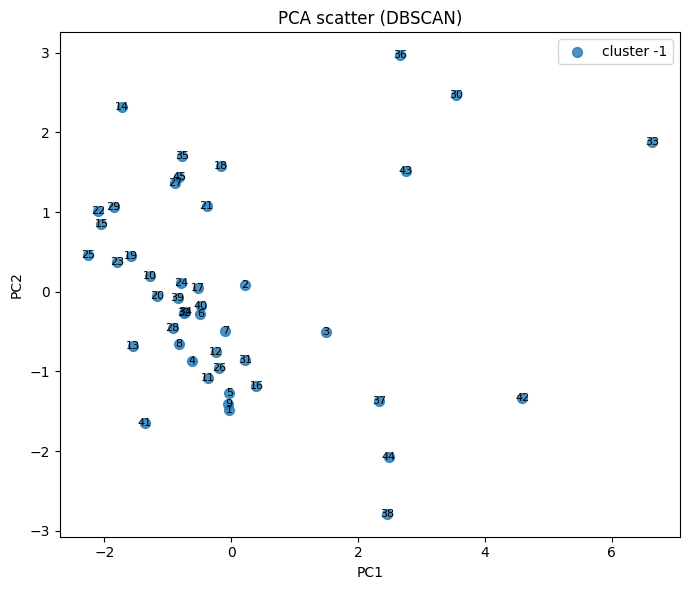

[DBSCAN] metrics: {'silhouette': nan, 'calinski_harabasz': nan, 'davies_bouldin': nan, 'n_clusters': 0}


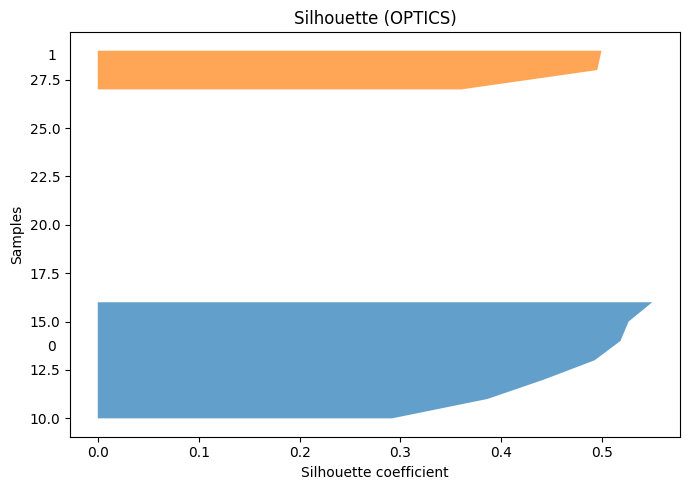

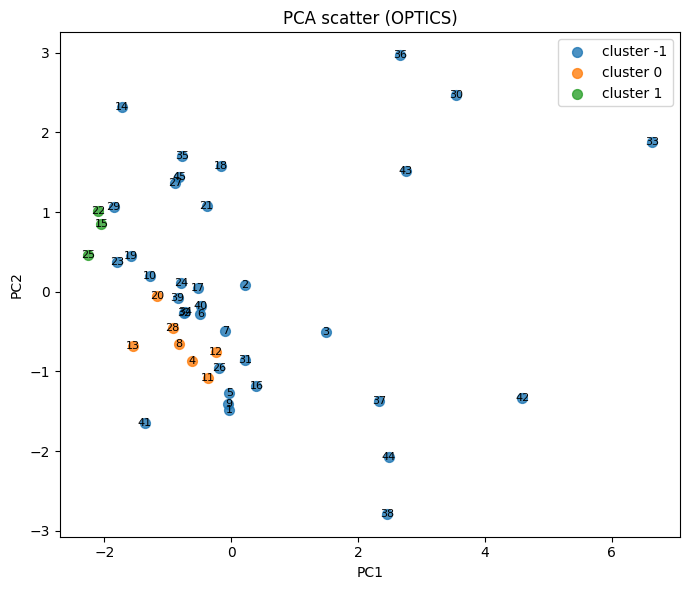

[OPTICS] metrics: {'silhouette': 0.45597622582487246, 'calinski_harabasz': 11.01376162912839, 'davies_bouldin': 0.7424819274397961, 'n_clusters': 2}
Silhouette (HDBSCAN pkg): skipped (need >=2 non-noise clusters).


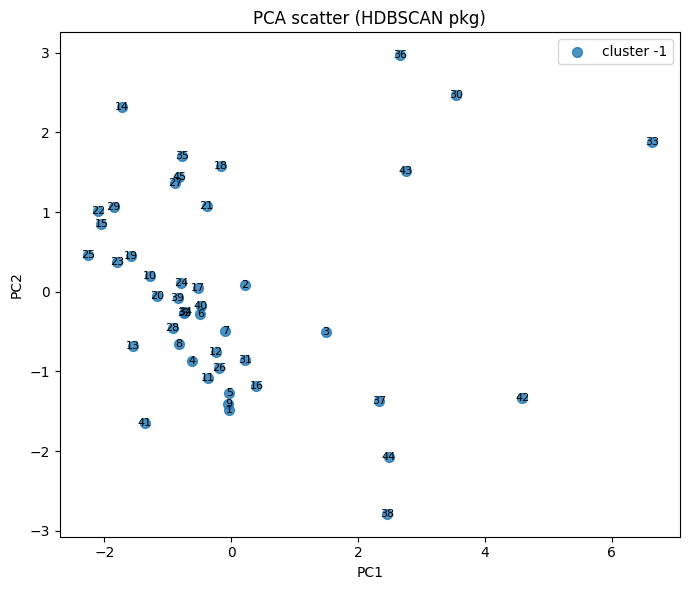

[HDBSCAN(pkg)] metrics: {'silhouette': nan, 'calinski_harabasz': nan, 'davies_bouldin': nan, 'n_clusters': 0}


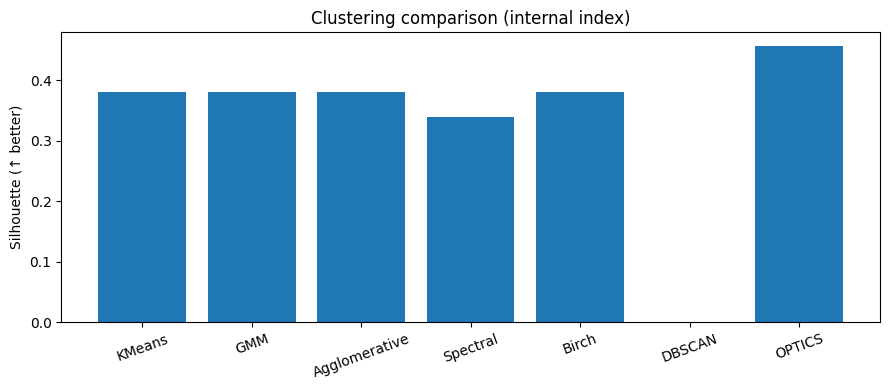


Cluster centroid interpretation (original feature scale):
  Cluster 0:
       uplift_easter: +0.131
    uplift_halloween: +0.012
          uplift_bts: +0.049
       md_elasticity: +0.142
          volatility: +0.143
       md_week_share: +0.358
        is_easter_cv: +0.086
     is_halloween_cv: +0.046
           is_bts_cv: +0.056
  Cluster 1:
       uplift_easter: +0.025
    uplift_halloween: -0.044
          uplift_bts: +0.007
       md_elasticity: +0.182
          volatility: +0.091
       md_week_share: +0.364
        is_easter_cv: +0.321
     is_halloween_cv: +0.158
           is_bts_cv: +0.100

=== ANOVA: uplift differences across KMeans clusters ===
[uplift_easter] F=30.655, p=0.0000
[uplift_halloween] F=14.590, p=0.0004
[uplift_bts] F=6.026, p=0.0182

=== Mini classification: predict BTS-sensitive stores (top quartile) ===
[Mini classification] Predict BTS-sensitive stores: mean acc=0.69, mean F1=0.21

Sample of store feature table with KMeans cluster:
 Store  uplift_easter  up

In [7]:
# walmart_holiday_sensitivity_eda_cluster.py
# ============================================================
# GOAL: Cluster Walmart stores by HOLIDAY SENSITIVITY
# (Easter / Halloween / Back-to-School)
# + Full EDA (inline plots)
# + Statistical tests (ANOVA + Tukey HSD)
# + Multi-model clustering suite with diagnostics
# + Small classification task: predict BTS-sensitive stores
#
# If optional libs are missing, those models are skipped:
#   - KMedoids -> pip install scikit-learn-extra
#   - HDBSCAN  -> pip install hdbscan  (or use sklearn.cluster.HDBSCAN if available)
#
# Requirements:
#   pip install pandas numpy scipy scikit-learn statsmodels matplotlib
#   # optional:
#   pip install scikit-learn-extra hdbscan
# ============================================================

import os
import warnings
from typing import List, Tuple, Dict
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, Birch, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score
)
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.multicomp import MultiComparison

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Optional algos
HAS_SKLEARN_EXTRA = True
try:
    from sklearn_extra.cluster import KMedoids
except Exception:
    HAS_SKLEARN_EXTRA = False

HAS_HDBSCAN_SKLEARN = False
HAS_HDBSCAN_PKG = False
try:
    # Newer scikit-learn has sklearn.cluster.HDBSCAN
    from sklearn.cluster import HDBSCAN as SKL_HDBSCAN
    HAS_HDBSCAN_SKLEARN = True
except Exception:
    try:
        # Fallback to external package hdbscan
        from hdbscan import HDBSCAN as PKG_HDBSCAN
        HAS_HDBSCAN_PKG = True
    except Exception:
        pass

# ------------------------- CONFIG -------------------------
DEFAULT_DATA_DIR = "/kaggle/input/walmart-recruiting-store-sales-forecasting"
DATA_DIR = os.getenv("DATA_DIR", DEFAULT_DATA_DIR)
UNZIP_DIR = os.getenv("UNZIP_DIR", "/kaggle/working/walmart_unzipped")

SEED = 42
np.random.seed(SEED)

# Events of interest
EASTER_DATES = ["2010-04-04", "2011-04-24", "2012-04-08"]
HALLOWEEN_DATES = ["2010-10-31", "2011-10-31", "2012-10-31"]
BTS_WINDOWS = [("2010-08-01", "2010-09-15"),
               ("2011-08-01", "2011-09-15"),
               ("2012-08-01", "2012-09-15")]

EVENT_WEEK_TOL_DAYS = 3
EPS = 1e-9
WINSOR_P = 0.01

# ------------------------- HELPERS -------------------------
def _to_dt(s): return pd.to_datetime(s, format="%Y-%m-%d")

def mark_event_weeks(dates: pd.Series, event_dates: List[str]) -> pd.Series:
    d = pd.to_datetime(dates)
    flag = np.zeros(len(d), dtype=bool)
    for ed in [_to_dt(x) for x in event_dates]:
        flag |= (d >= ed - pd.Timedelta(days=EVENT_WEEK_TOL_DAYS)) & (d <= ed + pd.Timedelta(days=EVENT_WEEK_TOL_DAYS))
    return pd.Series(flag, index=dates.index)

def mark_range_weeks(dates: pd.Series, ranges: List[Tuple[str, str]]) -> pd.Series:
    d = pd.to_datetime(dates)
    flag = np.zeros(len(d), dtype=bool)
    for lo, hi in ranges:
        flag |= (d >= _to_dt(lo)) & (d <= _to_dt(hi))
    return pd.Series(flag, index=dates.index)

def robust_ratio(numer, denom, eps=EPS):
    return (numer - denom) / (denom + eps)

def winsorize_series(s: pd.Series, p=WINSOR_P):
    lo, hi = s.quantile(p), s.quantile(1 - p)
    return s.clip(lo, hi)

# ------------------------- UNZIP LOGIC -------------------------
def _extract_zip(zip_path: str, target_dir: str) -> List[str]:
    os.makedirs(target_dir, exist_ok=True)
    extracted = []
    with ZipFile(zip_path) as zf:
        zf.extractall(target_dir)
        for name in zf.namelist():
            extracted.append(os.path.join(target_dir, name))
    return extracted

def _map_file(data_dir: str, base: str, unzip_dir: str) -> str:
    csv_path = os.path.join(data_dir, base)
    zip_path = os.path.join(data_dir, base + ".zip")
    if os.path.exists(csv_path):
        return csv_path
    if os.path.exists(zip_path):
        extracted = _extract_zip(zip_path, unzip_dir)
        for p in extracted:
            if p.lower().endswith(base.lower()):
                return p
        for p in extracted:
            if p.lower().endswith(".csv"):
                return p
        raise FileNotFoundError(f"No CSV found inside {zip_path}")
    raise FileNotFoundError(f"Neither {csv_path} nor {zip_path} found")

def prepare_data_files(data_dir: str = DATA_DIR, unzip_dir: str = UNZIP_DIR) -> Dict[str, str]:
    expected = ["train.csv", "features.csv", "stores.csv", "test.csv", "sampleSubmission.csv"]
    paths = {}
    for base in expected:
        try:
            paths[base] = _map_file(data_dir, base, unzip_dir)
        except FileNotFoundError:
            try:
                paths[base] = _map_file(".", base, unzip_dir)  # fallback to CWD
            except FileNotFoundError:
                if base != "sampleSubmission.csv":
                    raise
    print("Resolved paths:")
    for k, v in paths.items():
        print(f"  {k}: {v}")
    return paths

# ------------------------- LOAD & MERGE -------------------------
def load_data(paths: Dict[str, str]):
    train = pd.read_csv(paths["train.csv"])
    stores = pd.read_csv(paths["stores.csv"])
    feats  = pd.read_csv(paths["features.csv"])

    train["Date"] = pd.to_datetime(train["Date"])
    feats["Date"] = pd.to_datetime(feats["Date"])

    df = (train
          .merge(feats, on=["Store", "Date", "IsHoliday"], how="left")
          .merge(stores, on="Store", how="left"))

    md_cols = [c for c in df.columns if c.startswith("MarkDown")]
    for c in md_cols:
        df[c + "_missing"] = df[c].isna().astype(int)
        df[c] = df[c].fillna(0.0)

    # Sort before fill; then transform preserves index so assignment is safe
    df = df.sort_values(["Store", "Date"])
    for c in ["Temperature", "Fuel_Price", "CPI", "Unemployment"]:
        if c in df.columns:
            df[c] = df.groupby("Store")[c].transform(lambda s: s.ffill().bfill())
    df = df.sort_index()

    df["Year"] = df["Date"].dt.year
    df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
    return df, stores

def annotate_events(df: pd.DataFrame):
    df = df.copy()
    df["is_easter"] = mark_event_weeks(df["Date"], EASTER_DATES).astype(int)
    df["is_halloween"] = mark_event_weeks(df["Date"], HALLOWEEN_DATES).astype(int)
    df["is_bts"] = mark_range_weeks(df["Date"], BTS_WINDOWS).astype(int)
    df["is_any_selected_event"] = (df["is_easter"] | df["is_halloween"] | df["is_bts"]).astype(int)

    def event_label(row):
        if row["is_easter"] == 1: return "easter"
        if row["is_halloween"] == 1: return "halloween"
        if row["is_bts"] == 1: return "bts"
        return "none"
    df["event_label"] = df.apply(event_label, axis=1)
    return df

# ------------------------- BASELINE & UPLIFTS -------------------------
def compute_department_baseline(df):
    non_evt = df[df["is_any_selected_event"] == 0]
    base = (non_evt
            .groupby(["Store", "Dept"], as_index=False)["Weekly_Sales"]
            .median()
            .rename(columns={"Weekly_Sales": "baseline_dept"}))
    return base

def compute_store_uplifts(df, base):
    df = df.merge(base, on=["Store", "Dept"], how="left")
    df["baseline_dept"] = df["baseline_dept"].fillna(df["Weekly_Sales"].median())

    # Dept share weights
    share = (df.groupby(["Store", "Dept"], as_index=False)["baseline_dept"].first())
    share["sum_store"] = share.groupby("Store")["baseline_dept"].transform("sum")
    share["w"] = share["baseline_dept"] / (share["sum_store"] + EPS)
    df = df.merge(share[["Store", "Dept", "w"]], on=["Store", "Dept"], how="left").fillna({"w": 0.0})

    out = []
    for ev, col in [("easter", "is_easter"), ("halloween", "is_halloween"), ("bts", "is_bts")]:
        ev_df = df[df[col] == 1]
        med = (ev_df.groupby(["Store", "Dept"])["Weekly_Sales"]
                    .median().rename("event_med").reset_index())
        tmp = (med.merge(share[["Store", "Dept", "baseline_dept"]], on=["Store", "Dept"], how="left")
                   .merge(share[["Store", "Dept", "w"]], on=["Store", "Dept"], how="left"))
        tmp["uplift_dept"] = robust_ratio(tmp["event_med"], tmp["baseline_dept"])
        store = (tmp.assign(weighted=lambda d: d["uplift_dept"] * d["w"])
                   .groupby("Store", as_index=False)["weighted"].sum())
        store = store.rename(columns={"weighted": f"uplift_{ev}"})
        out.append(store)

    store_feats = out[0]
    for z in out[1:]:
        store_feats = store_feats.merge(z, on="Store", how="outer")

    # Weekly store sales volatility (std/mean)
    sw = (df.groupby(["Store", "Date"], as_index=False)["Weekly_Sales"]
            .sum().rename(columns={"Weekly_Sales": "store_week_sales"}))
    vol = (sw.groupby("Store")["store_week_sales"]
             .agg(["mean", "std"])
             .rename(columns={"mean": "mu", "std": "sigma"})).reset_index()
    vol["volatility"] = vol["sigma"] / (vol["mu"] + EPS)

    # Markdown elasticity proxy
    md_cols = [c for c in df.columns if c.startswith("MarkDown") and not c.endswith("_missing")]
    if md_cols:
        mw = df.groupby(["Store", "Date"], as_index=False)[md_cols + ["Weekly_Sales"]].sum()
        elast = []
        for s, g in mw.groupby("Store"):
            X = g[md_cols].sum(axis=1).values
            y = g["Weekly_Sales"].values
            if X.std() < 1e-6 or y.std() < 1e-6:
                coef = 0.0
            else:
                Xz = (X - X.mean()) / X.std()
                yz = (y - y.mean()) / y.std()
                coef = float(np.dot(Xz, yz) / (np.dot(Xz, Xz) + EPS))
            elast.append((s, coef))
        elast = pd.DataFrame(elast, columns=["Store", "md_elasticity"])
    else:
        elast = pd.DataFrame({"Store": store_feats["Store"], "md_elasticity": 0.0})

    # Share of weeks with any markdown
    if md_cols:
        mdw = (df.assign(md_sum=df[md_cols].sum(axis=1))
                 .groupby("Store")["md_sum"].agg(["count", lambda s: (s > 0).sum()]).reset_index())
        mdw.columns = ["Store", "week_count", "md_weeks"]
        mdw["md_week_share"] = mdw["md_weeks"] / (mdw["week_count"] + EPS)
    else:
        mdw = pd.DataFrame({"Store": store_feats["Store"], "md_week_share": 0.0})

    # Event variability across years (CV)
    def event_cv(df_in, flag_col):
        g = df_in[df_in[flag_col] == 1].groupby(["Store", df_in["Date"].dt.year])["Weekly_Sales"].median().reset_index()
        cv = g.groupby("Store")["Weekly_Sales"].agg(lambda s: s.std()/(s.mean()+EPS)).rename(f"{flag_col}_cv").reset_index()
        return cv

    easter_cv = event_cv(df, "is_easter")
    halloween_cv = event_cv(df, "is_halloween")
    bts_cv = event_cv(df, "is_bts")

    store_feats = (store_feats
                   .merge(vol[["Store", "volatility"]], on="Store", how="left")
                   .merge(elast, on="Store", how="left")
                   .merge(mdw[["Store", "md_week_share"]], on="Store", how="left")
                   .merge(easter_cv, on="Store", how="left")
                   .merge(halloween_cv, on="Store", how="left")
                   .merge(bts_cv, on="Store", how="left"))

    # Winsorize heavy tails
    for c in ["uplift_easter", "uplift_halloween", "uplift_bts", "md_elasticity", "volatility",
              "is_easter_cv", "is_halloween_cv", "is_bts_cv", "md_week_share"]:
        if c in store_feats.columns:
            store_feats[c] = winsorize_series(store_feats[c].fillna(0.0))

    return store_feats

# ------------------------- EDA PLOTS -------------------------
def plot_missingness(df: pd.DataFrame, cols=None):
    if cols is None:
        cols = df.columns.tolist()
    sub = df[cols].copy()
    miss = sub.isna().mean().sort_values(ascending=False)
    nonzero = miss[miss > 0]

    if nonzero.empty:
        missing_flags = [c for c in df.columns if c.endswith("_missing")]
        if missing_flags:
            flag_share = df[missing_flags].mean().sort_values(ascending=False)
            plt.figure(figsize=(8, 4))
            flag_share.plot(kind="bar")
            plt.ylabel("Missing fraction (from *_missing flags)")
            plt.title("Original missingness (before imputation)")
            plt.tight_layout(); plt.show()
        else:
            print("No missing values in selected columns; skipping missingness bar plot.")
            plt.figure(figsize=(6, 2))
            plt.text(0.5, 0.5, "No missing values in selected columns", ha="center", va="center")
            plt.axis("off"); plt.tight_layout(); plt.show()
        return

    plt.figure(figsize=(8, 4))
    nonzero.plot(kind="bar")
    plt.ylabel("Missing fraction")
    plt.title("Missingness by column")
    plt.tight_layout(); plt.show()

def plot_sales_distributions(df: pd.DataFrame):
    plt.figure(figsize=(7,4))
    s = df["Weekly_Sales"].dropna()
    plt.hist(s.values, bins=50)
    plt.xlabel("Weekly_Sales"); plt.ylabel("Count")
    plt.title("Distribution of Weekly Sales")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    s_pos = np.log1p(s.clip(lower=0))
    plt.hist(s_pos.values, bins=50)
    plt.xlabel("log1p(Weekly_Sales)"); plt.ylabel("Count")
    plt.title("Distribution of log1p(Weekly Sales)")
    plt.tight_layout(); plt.show()

def plot_time_series_examples(df: pd.DataFrame):
    sw = (df.groupby(["Store", "Date"], as_index=False)["Weekly_Sales"]
            .sum().rename(columns={"Weekly_Sales": "store_week_sales"}))
    vol = (sw.groupby("Store")["store_week_sales"].agg(["std"]).sort_values("std", ascending=False)).reset_index()
    top = vol["Store"].head(3).tolist()
    for s in top:
        plt.figure(figsize=(9,3))
        part = sw[sw["Store"] == s].sort_values("Date")
        plt.plot(part["Date"], part["store_week_sales"])
        plt.title(f"Store {s}: weekly sales")
        plt.xlabel("Date"); plt.ylabel("Sales")
        plt.tight_layout(); plt.show()

def plot_event_boxplots(df: pd.DataFrame):
    groups = ["none","easter","halloween","bts"]
    data = [df.loc[df["event_label"]==g, "Weekly_Sales"].dropna().values for g in groups]
    plt.figure(figsize=(7,4))
    plt.boxplot(data, labels=groups, showfliers=False)
    plt.ylabel("Weekly_Sales"); plt.title("Weekly Sales by Event Group (pooled)")
    plt.tight_layout(); plt.show()

def plot_markdown_hist(df: pd.DataFrame):
    md_cols = [c for c in df.columns if c.startswith("MarkDown") and not c.endswith("_missing")]
    if not md_cols: return
    plt.figure(figsize=(7,4))
    md_sum = df[md_cols].sum(axis=1)
    plt.hist(md_sum.values, bins=50)
    plt.xlabel("Total weekly markdown (MarkDown1..5)"); plt.ylabel("Count")
    plt.title("Distribution of total weekly markdown")
    plt.tight_layout(); plt.show()

def plot_corr_heatmap(df: pd.DataFrame):
    md_cols = [c for c in df.columns if c.startswith("MarkDown") and not c.endswith("_missing")]
    vars_ = ["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment"] + md_cols
    z = df[vars_].dropna()
    if z.empty:
        print("Correlation heatmap skipped (no data after dropna).")
        return
    C = np.corrcoef(z.values.T)
    plt.figure(figsize=(8,6))
    plt.imshow(C, aspect="auto")
    plt.xticks(range(len(vars_)), vars_, rotation=45, ha="right")
    plt.yticks(range(len(vars_)), vars_)
    plt.colorbar(label="Correlation")
    plt.title("Correlation matrix (weekly totals)")
    plt.tight_layout(); plt.show()

# ------------------------- STATISTICAL TESTS -------------------------
def run_anova(df: pd.DataFrame):
    groups = ["none","easter","halloween","bts"]
    samples = [df.loc[df["event_label"]==g, "Weekly_Sales"].dropna().values for g in groups
               if len(df.loc[df["event_label"]==g]) > 0]
    if sum([len(x)>0 for x in samples]) < 2:
        print("ANOVA skipped (not enough non-empty groups)."); return
    F, p = stats.f_oneway(*samples)
    print(f"[ANOVA] Weekly_Sales across (none,easter,halloween,bts): F={F:.3f}, p={p:.3g}")
    try:
        mc = MultiComparison(df["Weekly_Sales"], df["event_label"])
        res = mc.tukeyhsd()
        print("\n[Tukey HSD] Pairwise differences between event groups:")
        print(res.summary())
    except Exception as e:
        print(f"Post-hoc test skipped ({e}).")

# ------------------------- CLUSTERING HELPERS -------------------------
def choose_k_elbow_silhouette(X: np.ndarray, k_list=range(2,9)):
    inertias, sils = [], []
    for k in k_list:
        km = KMeans(n_clusters=k, random_state=SEED, n_init="auto")
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        sil = silhouette_score(X, labels) if len(np.unique(labels))>1 else np.nan
        sils.append(sil)

    # Elbow
    plt.figure(figsize=(6,4)); plt.plot(list(k_list), inertias, marker="o")
    plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow curve (KMeans)")
    plt.tight_layout(); plt.show()

    # Sil vs k
    plt.figure(figsize=(6,4)); plt.plot(list(k_list), sils, marker="o")
    plt.xlabel("k"); plt.ylabel("Mean silhouette"); plt.title("Silhouette vs k")
    plt.tight_layout(); plt.show()

    k_best = list(k_list)[int(np.nanargmax(sils))]
    return k_best

def silhouette_plot_safe(X: np.ndarray, labels: np.ndarray, title="Silhouette plot"):
    # filter out noise (-1) and ensure >=2 clusters
    mask = labels != -1
    uniq = np.unique(labels[mask])
    if len(uniq) < 2:
        print(f"{title}: skipped (need >=2 non-noise clusters).")
        return
    s_vals = silhouette_samples(X[mask], labels[mask])
    y_lower = 10
    plt.figure(figsize=(7,5))
    for c in uniq:
        si = np.sort(s_vals[labels[mask] == c])
        size_c = si.shape[0]
        y_upper = y_lower + size_c
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, si, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5*size_c, str(c))
        y_lower = y_upper + 10
    plt.xlabel("Silhouette coefficient"); plt.ylabel("Samples")
    plt.title(title)
    plt.tight_layout(); plt.show()

def pca_scatter(X: np.ndarray, labels: np.ndarray, store_ids: np.ndarray, title: str):
    p = PCA(n_components=2, random_state=SEED).fit_transform(X)
    plt.figure(figsize=(7,6))
    for c in np.unique(labels):
        idx = labels == c
        plt.scatter(p[idx,0], p[idx,1], label=f"cluster {c}", alpha=0.8, s=50)
    for i, sid in enumerate(store_ids):
        plt.text(p[i,0], p[i,1], str(sid), fontsize=8, ha="center", va="center")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

def cluster_centroid_profile(centers: np.ndarray, feature_names: List[str], title: str):
    x = np.arange(len(feature_names))
    plt.figure(figsize=(9, 4 + 0.6*centers.shape[0]))
    for i in range(centers.shape[0]):
        plt.plot(x, centers[i], marker="o", label=f"cluster {i}")
    plt.xticks(x, feature_names, rotation=15)
    plt.ylabel("Standardized value")
    plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

def compute_indices(X, labels):
    mask = labels != -1
    uniq = np.unique(labels[mask])
    if len(uniq) < 2:
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan, "n_clusters": len(uniq)}
    return {
        "silhouette": float(silhouette_score(X[mask], labels[mask])),
        "calinski_harabasz": float(calinski_harabasz_score(X[mask], labels[mask])),
        "davies_bouldin": float(davies_bouldin_score(X[mask], labels[mask])),
        "n_clusters": int(len(uniq))
    }

def best_dbscan(X):
    # Grid search a few eps on standardized space
    best = None
    for eps in [0.4, 0.5, 0.7, 0.9, 1.1, 1.3]:
        lab = DBSCAN(eps=eps, min_samples=3).fit_predict(X)
        m = compute_indices(X, lab)["silhouette"]
        if np.isnan(m):
            continue
        if (best is None) or (m > best[0]):
            best = (m, eps, lab)
    if best is None:  # fallback single run
        lab = DBSCAN(eps=0.9, min_samples=3).fit_predict(X)
        return lab, {"note": "no good eps found"}
    return best[2], {"best_eps": best[1], "silhouette": best[0]}

# ------------------------- MULTI-CLUSTER RUNNER -------------------------
def run_multi_clustering(X: np.ndarray, store_ids: np.ndarray, feature_names: List[str], k_best: int):
    results = {}

    # 1) KMeans
    km = KMeans(n_clusters=k_best, random_state=SEED, n_init="auto")
    lab_km = km.fit_predict(X)
    metrics = compute_indices(X, lab_km); results["KMeans"] = metrics
    silhouette_plot_safe(X, lab_km, "Silhouette (KMeans)")
    pca_scatter(X, lab_km, store_ids, "PCA scatter (KMeans)")
    cluster_centroid_profile(km.cluster_centers_, feature_names, "Cluster centroids (KMeans, standardized)")
    print("[KMeans] metrics:", metrics)

    # 2) Gaussian Mixture (GMM)
    gmm = GaussianMixture(n_components=k_best, covariance_type="full", random_state=SEED)
    lab_gmm = gmm.fit_predict(X)
    metrics = compute_indices(X, lab_gmm); results["GMM"] = metrics
    silhouette_plot_safe(X, lab_gmm, "Silhouette (GMM)")
    pca_scatter(X, lab_gmm, store_ids, "PCA scatter (GMM)")
    print("[GMM] metrics:", metrics)

    # 3) Agglomerative (Ward)
    ag = AgglomerativeClustering(n_clusters=k_best, linkage="ward")
    lab_ag = ag.fit_predict(X)
    metrics = compute_indices(X, lab_ag); results["Agglomerative"] = metrics
    silhouette_plot_safe(X, lab_ag, "Silhouette (Agglomerative)")
    pca_scatter(X, lab_ag, store_ids, "PCA scatter (Agglomerative)")
    print("[Agglomerative] metrics:", metrics)

    # 4) Spectral
    sp = SpectralClustering(n_clusters=k_best, assign_labels="kmeans", random_state=SEED, affinity="rbf")
    lab_sp = sp.fit_predict(X)
    metrics = compute_indices(X, lab_sp); results["Spectral"] = metrics
    silhouette_plot_safe(X, lab_sp, "Silhouette (Spectral)")
    pca_scatter(X, lab_sp, store_ids, "PCA scatter (Spectral)")
    print("[Spectral] metrics:", metrics)

    # 5) Birch (cluster readout at leaves)
    br = Birch(n_clusters=k_best)
    lab_br = br.fit_predict(X)
    metrics = compute_indices(X, lab_br); results["Birch"] = metrics
    silhouette_plot_safe(X, lab_br, "Silhouette (Birch)")
    pca_scatter(X, lab_br, store_ids, "PCA scatter (Birch)")
    print("[Birch] metrics:", metrics)

    # 6) KMedoids (optional)
    if HAS_SKLEARN_EXTRA:
        try:
            kmed = KMedoids(n_clusters=k_best, method="pam", random_state=SEED)
        except Exception:
            kmed = KMedoids(n_clusters=k_best, random_state=SEED)
        lab_md = kmed.fit_predict(X)
        metrics = compute_indices(X, lab_md); results["KMedoids"] = metrics
        silhouette_plot_safe(X, lab_md, "Silhouette (KMedoids)")
        pca_scatter(X, lab_md, store_ids, "PCA scatter (KMedoids)")
        print("[KMedoids] metrics:", metrics)
    else:
        print("KMedoids skipped (install scikit-learn-extra to enable).")

    # 7) DBSCAN (auto eps grid)
    lab_db, info = best_dbscan(X)
    metrics = compute_indices(X, lab_db); results["DBSCAN"] = metrics | {"info": info}
    silhouette_plot_safe(X, lab_db, "Silhouette (DBSCAN)")
    pca_scatter(X, lab_db, store_ids, "PCA scatter (DBSCAN)")
    print("[DBSCAN] metrics:", metrics)

    # 8) OPTICS
    op = OPTICS(min_samples=3, xi=0.05, min_cluster_size=3)
    lab_op = op.fit_predict(X)
    metrics = compute_indices(X, lab_op); results["OPTICS"] = metrics
    silhouette_plot_safe(X, lab_op, "Silhouette (OPTICS)")
    pca_scatter(X, lab_op, store_ids, "PCA scatter (OPTICS)")
    print("[OPTICS] metrics:", metrics)

    # 9) HDBSCAN (sklearn or external)
    if HAS_HDBSCAN_SKLEARN:
        hb = SKL_HDBSCAN(min_cluster_size=3)
        lab_hb = hb.fit_predict(X)
        metrics = compute_indices(X, lab_hb); results["HDBSCAN"] = metrics
        silhouette_plot_safe(X, lab_hb, "Silhouette (HDBSCAN)")
        pca_scatter(X, lab_hb, store_ids, "PCA scatter (HDBSCAN)")
        print("[HDBSCAN] metrics:", metrics)
    elif HAS_HDBSCAN_PKG:
        hb = PKG_HDBSCAN(min_cluster_size=3)
        lab_hb = hb.fit_predict(X)
        metrics = compute_indices(X, lab_hb); results["HDBSCAN(pkg)"] = metrics
        silhouette_plot_safe(X, lab_hb, "Silhouette (HDBSCAN pkg)")
        pca_scatter(X, lab_hb, store_ids, "PCA scatter (HDBSCAN pkg)")
        print("[HDBSCAN(pkg)] metrics:", metrics)
    else:
        print("HDBSCAN skipped (install hdbscan or use sklearn >= 1.3).")

    # Summary bar of Silhouette scores
    names = list(results.keys())
    vals = [results[n]["silhouette"] for n in names]
    plt.figure(figsize=(9,4))
    plt.bar(names, vals)
    plt.ylabel("Silhouette (↑ better)"); plt.title("Clustering comparison (internal index)")
    plt.xticks(rotation=20)
    plt.tight_layout(); plt.show()

    return results

# ------------------------- MINI CLASSIFICATION -------------------------
def mini_classification(store_feats: pd.DataFrame, stores_meta: pd.DataFrame = None):
    """
    Predict 'BTS-sensitive' (top quartile uplift_bts) from meta features.
    Robust to duplicated merges; guarantees numeric X.
    """
    df = store_feats.copy()

    if stores_meta is not None and not (("Type" in df.columns) and ("Size" in df.columns)):
        df = df.merge(stores_meta, on="Store", how="left", suffixes=("", "_meta"))

    def coalesce_col(frame, base, candidates):
        if base in frame.columns:
            return frame[base]
        for cand in candidates:
            if cand in frame.columns:
                return frame[cand]
        return pd.Series([np.nan] * len(frame), index=frame.index)

    df["Type"] = coalesce_col(df, "Type", ["Type_meta", "Type_x", "Type_y"]).fillna("A")
    df["Size"] = pd.to_numeric(coalesce_col(df, "Size", ["Size_meta", "Size_x", "Size_y"]), errors="coerce")
    df["Size"] = df["Size"].fillna(df["Size"].median())

    thr = df["uplift_bts"].quantile(0.75)
    df["target_bts_sensitive"] = (df["uplift_bts"] >= thr).astype(int)

    type_dum = pd.get_dummies(df["Type"], prefix="Type", drop_first=True)

    base_cols = []
    for c in ["Size", "md_week_share", "is_easter_cv", "is_halloween_cv", "is_bts_cv",
              "volatility", "md_elasticity"]:
        if c in df.columns:
            base_cols.append(pd.to_numeric(df[c], errors="coerce"))
    X_df = pd.concat(base_cols + [type_dum], axis=1).fillna(0.0)
    y = df["target_bts_sensitive"].values

    cont_cols = [c for c in X_df.columns if not c.startswith("Type_")]
    scaler = StandardScaler()
    Xc = X_df.copy()
    if cont_cols:
        Xc[cont_cols] = scaler.fit_transform(X_df[cont_cols])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    accs, f1s = [], []
    for tr, te in skf.split(Xc.values, y):
        clf = LogisticRegression(max_iter=2000)
        clf.fit(Xc.values[tr], y[tr])
        yhat = clf.predict(Xc.values[te])
        accs.append((yhat == y[te]).mean())
        tp = ((yhat==1) & (y[te]==1)).sum()
        fp = ((yhat==1) & (y[te]==0)).sum()
        fn = ((yhat==0) & (y[te]==1)).sum()
        prec = tp / (tp+fp+EPS); rec = tp / (tp+fn+EPS)
        f1s.append(2*prec*rec/(prec+rec+EPS))
    print(f"[Mini classification] Predict BTS-sensitive stores: mean acc={np.mean(accs):.2f}, mean F1={np.mean(f1s):.2f}")

# ------------------------- MAIN -------------------------
def main():
    # Resolve paths & unzip if needed
    paths = prepare_data_files(DATA_DIR, UNZIP_DIR)

    # Load & annotate
    df, stores_meta = load_data(paths)
    df = annotate_events(df)

    # EDA
    print("Rows:", len(df), "| Unique stores:", df["Store"].nunique(), "| Unique depts:", df["Dept"].nunique())
    print(df.head(3))

    print("\nMissingness quick check (selected):")
    for c in ["Temperature","Fuel_Price","CPI","Unemployment","MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]:
        if c in df.columns:
            print(f"{c}: {df[c].isna().mean():.3f}")
    plot_missingness(
        df,
        cols=["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment"] +
             [c for c in df.columns if c.startswith("MarkDown") and not c.endswith("_missing")]
    )
    plot_sales_distributions(df)
    plot_markdown_hist(df)
    plot_time_series_examples(df)
    plot_event_boxplots(df)

    df_corr = (df.groupby(["Store","Date"], as_index=False)
                 .agg(Weekly_Sales=("Weekly_Sales","sum"),
                      Temperature=("Temperature","mean"),
                      Fuel_Price=("Fuel_Price","mean"),
                      CPI=("CPI","mean"),
                      Unemployment=("Unemployment","mean"),
                      MarkDown1=("MarkDown1","sum"),
                      MarkDown2=("MarkDown2","sum"),
                      MarkDown3=("MarkDown3","sum"),
                      MarkDown4=("MarkDown4","sum"),
                      MarkDown5=("MarkDown5","sum")))
    plot_corr_heatmap(df_corr)

    # Stats tests
    print("\n=== One-way ANOVA across event groups (pooled) ===")
    run_anova(df)

    # Store-level features & clustering
    print("\nBuilding store-level features…")
    base = compute_department_baseline(df)
    store_feats = compute_store_uplifts(df, base)
    store_feats = store_feats.merge(stores_meta, on="Store", how="left")

    feat_cols = ["uplift_easter","uplift_halloween","uplift_bts",
                 "md_elasticity","volatility","md_week_share",
                 "is_easter_cv","is_halloween_cv","is_bts_cv"]
    for c in feat_cols:
        if c not in store_feats.columns:
            store_feats[c] = 0.0

    F = store_feats[feat_cols].fillna(0.0).values
    scaler = StandardScaler()
    X = scaler.fit_transform(F)

    k_best = choose_k_elbow_silhouette(X, k_list=range(2,9))
    print(f"Chosen k via max silhouette: k={k_best}")

    # Run all clustering algos + plots + metrics
    results = run_multi_clustering(X, store_feats["Store"].values, feat_cols, k_best)

    # Interpret KMeans centroids on original scale
    km = KMeans(n_clusters=k_best, random_state=SEED, n_init="auto").fit(X)
    centers_denorm = scaler.inverse_transform(km.cluster_centers_)
    print("\nCluster centroid interpretation (original feature scale):")
    for i, v in enumerate(centers_denorm):
        print(f"  Cluster {i}:")
        for name, val in zip(feat_cols, v):
            print(f"    {name:>16}: {val:+.3f}")

    # ANOVA across clusters (KMeans) for core uplifts
    tmp = store_feats.copy(); tmp["cluster"] = km.labels_
    print("\n=== ANOVA: uplift differences across KMeans clusters ===")
    for col in ["uplift_easter","uplift_halloween","uplift_bts"]:
        groups = [tmp.loc[tmp["cluster"]==g, col].dropna().values for g in np.unique(km.labels_)]
        if len(groups) >= 2 and min(map(len, groups)) >= 2:
            Fv, pv = stats.f_oneway(*groups)
            print(f"[{col}] F={Fv:.3f}, p={pv:.4f}")

    # Mini classification
    print("\n=== Mini classification: predict BTS-sensitive stores (top quartile) ===")
    mini_classification(store_feats, stores_meta)

    # Quick preview table
    out_tbl = store_feats[["Store"] + feat_cols].copy()
    out_tbl["km_cluster"] = km.labels_
    print("\nSample of store feature table with KMeans cluster:")
    print(out_tbl.head(10).to_string(index=False))

if __name__ == "__main__":
    main()
